# Setup

In [ ]:
# Import necessary libraries

import pandas as pd
import pandas_datareader.data as web
from datetime import datetime

In [ ]:
# Set timeframe for the data
start_date = '2000-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')  # Today's date

# Economic Indicators from FRED we wish to analyze.
indicators = {
    'GDP': 'GDP',                 # Gross Domestic Product
    'CPI': 'CPIAUCSL',            # Consumer Price Index for All Urban Consumers: All Items
    'UNRATE': 'UNRATE',           # Unemployment Rate
    'FEDFUNDS': 'FEDFUNDS'        # Effective Federal Funds Rate
}

economic_data = pd.DataFrame()

# Fetch the data from FRED using the indicators.
for name, code in indicators.items():
    series = web.DataReader(code, "fred", start_date, end_date)
    economic_data = economic_data.join(series, how="outer") if not economic_data.empty else series

# Forward-fill any missing data points in the time series.
economic_data.ffill(inplace=True)

# Save our data to a CSV file.
economic_data.to_csv('economic_data.csv', index_label='DATE')

In [ ]:
# Load dataset
file_path = 'economic_data.csv'
economic_data = pd.read_csv(file_path, index_col='DATE', parse_dates=True)

# EDA

In [ ]:
economic_data.head()

,GDP,CPIAUCSL,UNRATE,FEDFUNDS
DATE,,,,
2000-01-01,10002.179,169.3,4.0,5.45
2000-02-01,10002.179,170.0,4.1,5.73
2000-03-01,10002.179,171.0,4.0,5.85
2000-04-01,10247.720,170.9,3.8,6.02
2000-05-01,10247.720,171.2,4.0,6.27


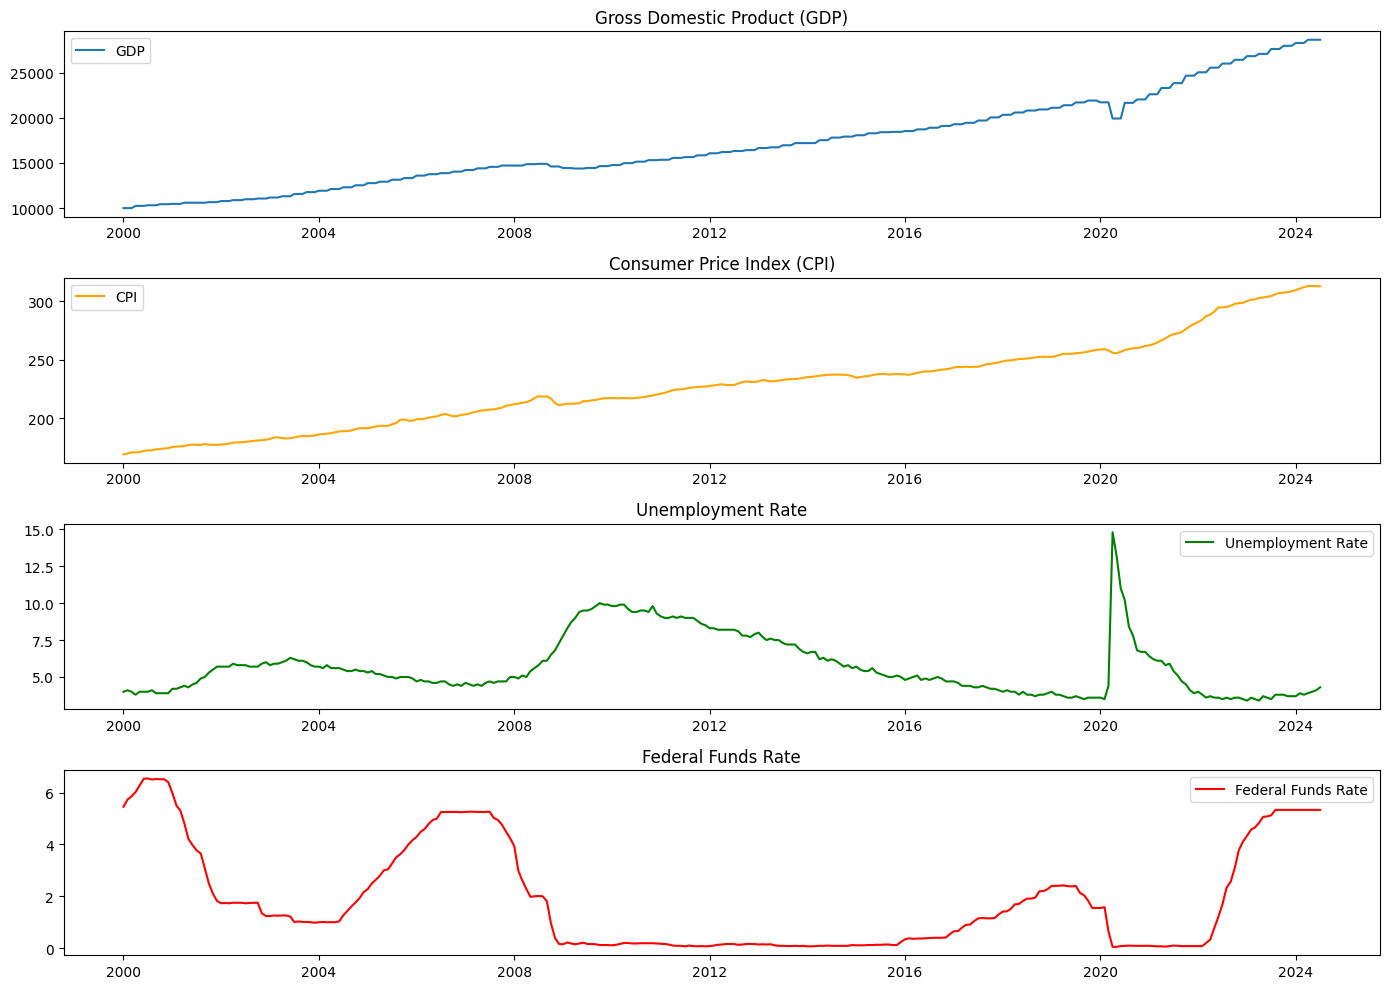

In [ ]:
# Data Visualization #
import matplotlib.pyplot as plt

# Plot each time series.
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(economic_data['GDP'], label='GDP')
plt.title('Gross Domestic Product (GDP)')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(economic_data['CPIAUCSL'], label='CPI', color='orange')
plt.title('Consumer Price Index (CPI)')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(economic_data['UNRATE'], label='Unemployment Rate', color='green')
plt.title('Unemployment Rate')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(economic_data['FEDFUNDS'], label='Federal Funds Rate', color='red')
plt.title('Federal Funds Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Initial Insights #

"""
I see that GDP increases fairly linearly over time, with slight fluctuations. The most notable of which are the slight dip after 2008 and the bucket-like drop following 2020.
  These can be explained due to the housing crisis and COVID shutdowns causing production issues respectively.

A similar trend can be seen in the CPI chart where the line is overall increasing linearly however dips slightly following the 2008 housing crisis because more people were struggling
  financially which caused general prices to fall (lack of demand) and increases in the severity of the slope following 2020 due to production issues still recovering from shutdowns
  (lack of supply) and general inflation driving up prices.

Unemployment Rate shows higher rates of fluctuation however also experiences its greatest changes following 2008 and 2020 with sharp increases. It is interesting to note the difference
  in severity of the slopes for 2008 and 2020. 2008 shows a more steady increase and subsequent decline in unemployment rate while 2020 shows a spike where many businesses were forced to
  close due to the pandemic and then a rapid descent when the economy began to get back on its feet.

The Federal Funds Rate shows the Federal Reserves varying monetary policy stances, with changes often reacting to economic conditions.
"""

'\nI see that GDP increases fairly linearly over time, with slight fluctuations. The most notable of which are the slight dip after 2008 and the bucket-like drop following 2020.\n  These can be explained due to the housing crisis and COVID shutdowns causing production issues respectively.\n\nA similar trend can be seen in the CPI chart where the line is overall increasing linearly however dips slightly following the 2008 housing crisis because more people were struggling\n  financially which caused general prices to fall (lack of demand) and increases in the severity of the slope following 2020 due to production issues still recovering from shutdowns\n  (lack of supply) and general inflation driving up prices.\n\nUnemployment Rate shows higher rates of fluctuation however also experiences its greatest changes following 2008 and 2020 with sharp increases. It is interesting to note the difference\n  in severity of the slopes for 2008 and 2020. 2008 shows a more steady increase and subseq

In [ ]:
# ADF Test to check stationarity of the time series data #
# The ADF Test shows to what extent each time series data is characterized by a unit root,
#   which would indicate non-stationarity #
# Non-stationary data can cause problems in time series forecasting #
# If the data is non-stationary, will need to stabilize the volatility of the data #

from statsmodels.tsa.stattools import adfuller

# Function to perform the ADF test
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
# Apply the ADF test on each series
print("GDP:")
adf_test(economic_data['GDP'].dropna())  # GDP has NaNs for months without a quarterly report

GDP:
Results of Dickey-Fuller Test:
Test Statistic                   1.761484
p-value                          0.998269
#Lags Used                      15.000000
Number of Observations Used    279.000000
Critical Value (1%)             -3.454008
Critical Value (5%)             -2.871956
Critical Value (10%)            -2.572320
dtype: float64


In [ ]:
"""
The GDP data has a Test Statistic of ~1.7615 whihc is greater than any of the Critical Values
The p-value (~0.9983) is also much greater than a typical alpha value of 0.05

Therefore I cannot reject the null hypothesis that the GDP data has a unit root and thus
the GDP data is non-stationary

Because of this I will need to stabilize the data with differencing or log transformation techniques
before using it in the forecasting model
"""

'\nThe GDP data has a Test Statistic of ~1.7615 whihc is greater than any of the Critical Values\nThe p-value (~0.9983) is also much greater than a typical alpha value of 0.05\n\nTherefore I cannot reject the null hypothesis that the GDP data has a unit root and thus\nthe GDP data is non-stationary\n\nBecause of this I will need to stabilize the data with differencing or log transformation techniques\nbefore using it in the forecasting model\n'

In [ ]:
print("\nCPI:")
adf_test(economic_data['CPIAUCSL'])


CPI:
Results of Dickey-Fuller Test:
Test Statistic                   0.931616
p-value                          0.993489
#Lags Used                      15.000000
Number of Observations Used    279.000000
Critical Value (1%)             -3.454008
Critical Value (5%)             -2.871956
Critical Value (10%)            -2.572320
dtype: float64


In [ ]:
"""
Again, the CPI data has a Test Statistic of ~1.7615 whihc is greater than any of the Critical Values
The p-value (~0.9983) is also much greater than a typical alpha value of 0.05

Therefore this is also non-stationary and will need to stabilized
"""

'\nAgain, the CPI data has a Test Statistic of ~1.7615 whihc is greater than any of the Critical Values\nThe p-value (~0.9983) is also much greater than a typical alpha value of 0.05\n\nTherefore this is also non-stationary and will need to stabilized\n'

In [ ]:
print("\nUnemployment Rate:")
adf_test(economic_data['UNRATE'])


Unemployment Rate:
Results of Dickey-Fuller Test:
Test Statistic                  -2.945543
p-value                          0.040303
#Lags Used                       0.000000
Number of Observations Used    294.000000
Critical Value (1%)             -3.452790
Critical Value (5%)             -2.871422
Critical Value (10%)            -2.572035
dtype: float64


In [ ]:
"""
For Unemployment Rate, the Test Statistic (-2.945543) is less than the Critical Value at 5% (-2.871422)
The p-value (0.040303) is also less than a typical alpha value of 0.05

Therefore we can reject the null hypothesis that the Unemployment Rate data has a unit root at a 5%
significance level and thus the Unemployment Rate data is stationary
"""

'\nFor Unemployment Rate, the Test Statistic (-2.945543) is less than the Critical Value at 5% (-2.871422)\nThe p-value (0.040303) is also less than a typical alpha value of 0.05\n\nTherefore we can reject the null hypothesis that the Unemployment Rate data has a unit root at a 5%\nsignificance level and thus the Unemployment Rate data is stationary\n'

In [ ]:
print("\nFederal Funds Rate:")
adf_test(economic_data['FEDFUNDS'])


Federal Funds Rate:
Results of Dickey-Fuller Test:
Test Statistic                  -3.690500
p-value                          0.004249
#Lags Used                       5.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64


In [ ]:
"""
Federal Funds Rate shows a Test Statistic of -3.6905 which is well below the Critical Values
The p-value of 0.004249 is also well below a typical alpha value of 0.05

Therefore we can reject the null hypothesis that the Federal Funds Rate data has a unit root and
conclude that the Federal Funds Rate data is stationary
"""

'\nFederal Funds Rate shows a Test Statistic of -3.6905 which is well below the Critical Values\nThe p-value of 0.004249 is also well below a typical alpha value of 0.05\n\nTherefore we can reject the null hypothesis that the Federal Funds Rate data has a unit root and\nconclude that the Federal Funds Rate data is stationary\n'

# Modeling

In [ ]:
"""
ARIMA (AutoRegressive Integrated Moving Average) model is a popular time series forecasting model specifically suited to data which has been differenced
  for stationarity so we will use it here.

It takes 3 parameters (p, d, q).

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.
"""

In [ ]:
# GDP and CPI diffs
economic_data['GDP_diff'] = economic_data['GDP'].diff().dropna()
economic_data['CPI_diff'] = economic_data['CPIAUCSL'].diff().dropna()

# Drop NaN values
gdp_diff_clean = economic_data['GDP_diff'].dropna()

In [ ]:
# The data has been differenced once so d = 1.
d = 1

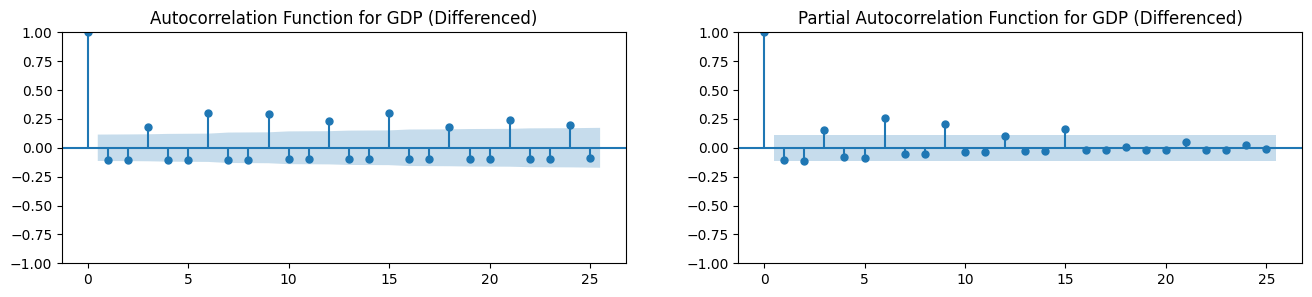

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the differenced GDP series to help determine the ARIMA model parameters p and q
fig, axes = plt.subplots(1, 2, figsize=(16,3))
plot_acf(gdp_diff_clean, ax=axes[0], title='Autocorrelation Function for GDP (Differenced)')
plot_pacf(gdp_diff_clean, ax=axes[1], title='Partial Autocorrelation Function for GDP (Differenced)')

plt.show()